# VERTICO VI: Environmental mechanisms quench star formation by reducing both molecular gas content and star formation efficiency in Virgo Cluster galaxies

**Author**: Toby Brown, March 2023

This is the notebook used to perform the analysis that is presented in Brown et al. (2023).

In [1]:
import sys

import astropy.units as u
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rsmf
import seaborn as sns
from astropy.table import Table
from ltsfit.lts_linefit import lts_linefit as lts
from matplotlib.ticker import MaxNLocator
from scipy import stats
from scipy.stats import binned_statistic

from matplotlib import rcParams

In [2]:
# Write plots and fits to file?
write_plots = True  # [bool]
write_tables = True  # [bool]

# 1. Load VERTICO and HERACLES data

In [3]:
# try and read from scratch for speed, if not read from data/
try:
    df = pd.read_parquet("/scratch/data/vertico_pix_data.df")
    heradf = pd.read_parquet("/scratch/data/heracles_pix_data.df")
except:
    df = pd.read_parquet("data/vertico_pix_data.df")
    heradf = pd.read_parquet("data/heracles_pix_data.df")

In [4]:
df.describe()

,mom0_Msun,mass_W1W3,sfr_nuv_w3,mom0_K,mom0_SN,mom0_unc,GALEX_NUV_SN,WISE1_SN,r_kpc,WISE3_SN,...,lgfmol,lgftot,hi-def_ms,hi-def_ms_err_lo,hi-def_ms_err_hi,viva_hi-def,viva_e_hi-def,delta_sfr,delta_fmol,delta_sfe
count,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.00000,...,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000
mean,12.304031,151.566328,0.006849,4.202932,28.903802,0.074857,219.678745,251.346597,4.103446,37.26618,...,-1.209234,-0.887439,0.505511,-0.056217,0.027939,0.471746,0.108944,-0.210330,-0.202565,-0.067731
std,20.481412,239.589307,0.012338,8.408789,44.543763,0.036727,326.041218,387.855562,2.301144,75.06202,...,0.410034,0.480961,0.622774,0.040557,0.022967,0.554638,0.070796,0.403509,0.429108,0.233062
min,0.233406,3.725712,0.000253,0.103772,2.001300,0.016186,11.100400,8.195500,0.008494,5.00304,...,-2.781170,-1.811700,-0.420000,-0.160000,0.000000,-0.810000,0.020000,-1.473230,-2.114593,-0.909087
25%,2.883036,47.681577,0.001959,0.925755,8.985690,0.047581,68.914900,84.153800,2.307420,9.72290,...,-1.548080,-1.324095,-0.030000,-0.080000,0.020000,0.120000,0.020000,-0.498798,-0.474407,-0.225682
50%,6.110502,87.580971,0.003658,1.878420,15.862900,0.067455,128.177000,143.275000,3.796330,17.76270,...,-1.079460,-0.848301,0.400000,-0.040000,0.020000,0.410000,0.120000,-0.197721,-0.190746,-0.082268
75%,13.183499,160.869738,0.007405,4.176600,32.690600,0.101712,251.539000,262.494000,5.637130,39.08910,...,-0.931210,-0.412803,1.120000,-0.030000,0.030000,0.920000,0.200000,0.077596,0.084025,0.067772
max,345.527851,3381.900949,0.319522,176.020000,1079.980000,0.223612,8957.800000,7809.530000,13.371200,2686.67000,...,-0.644110,0.210961,2.160000,0.000000,0.110000,2.250000,0.200000,0.984364,0.989757,1.236799


In [5]:
heradf.describe()

,CO_mom0_Msun,mass_W1W3,sfr_nuv_w3,CO_mom0_K,CO_mom0_SN,CO_mom0_unc,GALEX_NUV_SN,WISE1_SN,WISE3_SN,r_kpc,...,inclination_correction,lgms_dens,lgsfr_dens,lgmol_dens,lgsSFR,lgSFE,lgfmol,delta_sfr,delta_fmol,delta_sfe
count,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,...,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000,10794.000000
mean,17.670742,130.054166,0.008764,4.348717,12.671383,0.312151,332.412551,200.743406,177.537642,10.672823,...,0.771151,7.884241,-2.238779,1.025656,-10.026012,9.090492,-0.935520,-0.066474,-0.072185,-0.005553
std,30.886478,234.942505,0.011637,7.203092,15.868568,0.129293,406.807838,370.730253,231.527755,5.318962,...,0.155278,0.395023,0.388848,0.400731,0.261002,0.187303,0.236374,0.292732,0.319257,0.224879
min,0.419748,4.378960,0.000128,0.124889,2.002340,0.047707,5.182040,5.080850,5.389550,0.077842,...,0.447302,6.641371,-3.893590,-0.377011,-10.660000,7.874330,-1.585670,-1.271838,-1.820168,-1.314414
25%,5.649230,41.210563,0.003335,1.353347,5.166760,0.247367,75.182100,49.031875,54.629725,6.528478,...,0.751368,7.615009,-2.476905,0.751989,-10.170000,9.081370,-1.088630,-0.249283,-0.255308,-0.124999
50%,9.698160,69.164004,0.005647,2.336100,8.108350,0.287367,219.633000,103.209500,113.718000,10.213900,...,0.810906,7.839880,-2.248205,0.986689,-10.010000,9.126150,-0.921740,-0.043927,-0.046170,-0.013588
75%,18.330027,129.897391,0.010016,4.645722,14.067050,0.324609,418.552000,206.756500,198.494250,14.297725,...,0.870098,8.113600,-1.999304,1.263163,-9.850000,9.221240,-0.858760,0.132404,0.148408,0.117048
max,828.631938,3337.789375,0.276379,189.233000,380.188000,1.219960,4180.310000,5850.600000,2775.440000,39.013700,...,0.906461,9.523459,-0.558494,2.918362,-9.460000,9.327420,-0.583850,0.984495,0.794390,1.141495


In [6]:
print(
    "final sample contains {} pixels from {} galaxies".format(
        len(df), len(df["Galaxy"].unique())
    )
)

final sample contains 15401 pixels from 33 galaxies


# 2. Global properties

In [7]:
# fdescribeng http://hea-www.harvard.edu/~alexey/emulateapj/emulateapj.cls
# we fix aastex's definition of type sizes where their manuscript 12pt = revtex 10.56pt
formatter = rsmf.setup(r"\documentclass[a4paper,10.56pt]{revtex4-2}")

# use latex style
style = {"text.usetex": True, "font.family": "serif"}
rcParams.update(style)

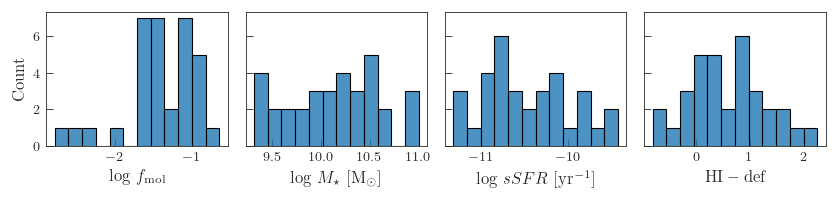

In [11]:
%matplotlib inline

groupdf = df.groupby("Galaxy").mean(numeric_only=True)

# init the figure object
fig = formatter.figure(wide=True, aspect_ratio=0.25)

# no. plots and bins per plot
n_plot = 4
n_bins = 12

# add the axes
axs = []

for i in range(n_plot):
    if i == 0:
        axs.append(fig.add_subplot(1, n_plot, i + 1))
    else:
        axs.append(fig.add_subplot(1, n_plot, i + 1, sharey=axs[0]))

# molecular gas fraction
hist = sns.histplot(
    groupdf,
    x="lgfmol",
    element="bars",
    log_scale=False,
    bins=n_bins,
    ax=axs[0],
    # color=global_color,
    alpha=0.8,
)

# stellar mass
hist = sns.histplot(
    groupdf,
    x="logmass_L19",
    element="bars",
    log_scale=False,
    bins=n_bins,
    ax=axs[1],
    # color=global_color,
    alpha=0.8,
)

# specific star formation rate
hist = sns.histplot(
    groupdf,
    x="lgsSFR",
    element="bars",
    log_scale=False,
    bins=n_bins,
    ax=axs[2],
    # color=global_color,
    alpha=0.8,
)

# HI-deficiency
hist = sns.histplot(
    groupdf,
    x="viva_hi-def",
    element="bars",
    log_scale=False,
    bins=n_bins,
    ax=axs[3],
    # color=global_color,
    alpha=0.8,
)

# tidy up the axes
for i in range(1, n_plot):
    axs[i].tick_params(labelleft=False)
    axs[i].set_ylabel("")

xlabels = [
    r"log $f_\mathrm{mol}$",
    r"log $M_\star$ [M$_{\odot}$]",
    r"log $sSFR$ [yr$^{-1}$]",
    r"$\mathrm{HI-def}$",
]


for ax, xlabel in zip(axs, xlabels):
    ax.set_xlabel(xlabel)

fig.subplots_adjust(hspace=0.05, wspace=0.05)

fig.tight_layout()

## How does global HI deficiency map to the Yoon+17 classes?

In [12]:
# group the Yoon classes into early (0), active (I + II), past (III + IV)
# pandas groupby doesn't like strings so we assign a numerical key that we'll convert in the next plot
df["y17_number"] = -99
df.loc[(df["y17_class"] == "0"), "y17_number"] = 0
df.loc[(df["y17_class"] == " I"), "y17_number"] = 1
df.loc[(df["y17_class"] == " II"), "y17_number"] = 2
df.loc[(df["y17_class"] == " III"), "y17_number"] = 3
df.loc[(df["y17_class"] == " IV"), "y17_number"] = 4

print(df["y17_class"].unique())
print(df["y17_number"].unique())

[' III' '0' ' I' ' II' ' IV']
[3 0 1 2 4]


In [13]:
# within or without truncation radius
df["r_re"] = df["r_kpc"] / df["r90_mol"]
df["disc_region"] = pd.cut(
    df["r_re"], bins=[0, 1, 100], right=False, labels=["inner disc", "outer disc"]
)

heradf["r_re"] = heradf["r_kpc"] / heradf["R_90"]
heradf["disc_region"] = pd.cut(
    heradf["r_re"], bins=[0, 1, 100], right=False, labels=["inner disc", "outer disc"]
)

In [17]:
# group and then assign labels
groupdf = df.groupby("Galaxy").mean(numeric_only=True)
groupdf.loc[groupdf["y17_number"] == 0, "y17_physical"] = "unperturbed"
groupdf.loc[groupdf["y17_number"] == 1, "y17_physical"] = "early RPS"
groupdf.loc[groupdf["y17_number"] == 2, "y17_physical"] = "active RPS"
groupdf.loc[groupdf["y17_number"] == 3, "y17_physical"] = "post RPS"
groupdf.loc[groupdf["y17_number"] == 4, "y17_physical"] = "anemic disc"

categories = [
    "field",
    "unperturbed",
    "early RPS",
    "active RPS",
    "post RPS",
    "anemic disc",
]

# set categorical order
groupdf["y17_physical"] = pd.Categorical(
    groupdf["y17_physical"],
    categories=categories[1:],
    ordered=True,
)

print(groupdf["y17_physical"].unique())

['post RPS', 'unperturbed', 'early RPS', 'active RPS', 'anemic disc']
Categories (5, object): ['unperturbed' < 'early RPS' < 'active RPS' < 'post RPS' < 'anemic disc']


In [18]:
groupdf["y17_physical"].value_counts().reindex(categories[1:])

unperturbed    9
early RPS      5
active RPS     5
post RPS       9
anemic disc    5
Name: y17_physical, dtype: int64

<ipython-input-19-739f721869b6>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  twiny.set_yticklabels(["", "0", "I", "II", "III", "IV"])


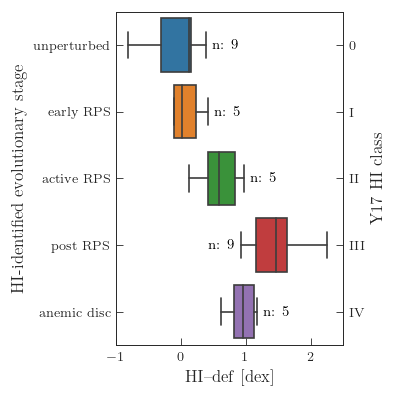

In [19]:
# set up the figure
fig = formatter.figure(aspect_ratio=1.0)
ax = fig.add_subplot()

h = sns.boxplot(
    data=groupdf,
    x="viva_hi-def",
    y="y17_physical",
    hue="y17_physical",
    orient="h",
    dodge=False,
    ax=ax,
)

# twin y showing Y17 classes
twiny = ax.twinx()
mn, mx = ax.get_ylim()
twiny.set_ylim(mn, mx)
twiny.set_yticklabels(["", "0", "I", "II", "III", "IV"])

ax.get_legend().remove()

# ax.hlines([3.5], -100, 100, color="grey", ls="-", lw=4, alpha=0.5, zorder=0)
ax.set_xlim(-1, 2.5)


# posterior
twiny.set_ylabel(r"Y17 H{\sc I} class")
ax.set_ylabel(r"H{\sc I}-identified evolutionary stage")
ax.set_xlabel(r"H{\sc I}--def [dex]")

# add value counts
nobs = groupdf["y17_physical"].value_counts().reindex(categories[1:])
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# medians = groupdf.groupby(['y17_physical'])['viva_hi-def'].mean().values
quantile_r = groupdf.groupby(["y17_physical"])["viva_hi-def"].quantile(1)
quantile_l = groupdf.groupby(["y17_physical"])["viva_hi-def"].quantile(0)
quantile = quantile_r.copy()
quantile["post RPS"] = quantile_l["post RPS"] - 0.6

pos = range(len(nobs))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(
        quantile[tick] + 0.3,
        pos[tick],
        nobs[tick],
        horizontalalignment="center",
        size="small",
        color="k",
        ha="center",
        va="center",
    )

fig.tight_layout()

if write_plots:
    fig.savefig(
        "figs/hi-def_Y17.pdf",
        metadata={
            "Author": "Toby Brown",
        },
        bbox_inches="tight",
    )

In [20]:
# We have to combine the df with HERACLES

# group and then assign labels
heradf["y17_number"] = -1
combined_col_list = [
    "Galaxy",
    "lgmol_dens",
    "lgms_dens",
    "lgsfr_dens",
    "y17_number",
    "delta_fmol",
    "delta_sfe",
    "delta_sfr",
    "disc_region",
    "survey",
]

df["survey"] = "VERTICO"
heradf["survey"] = "HERACLES"
comb_df = pd.concat([df[combined_col_list], heradf[combined_col_list]], axis=0)

comb_df.loc[comb_df["y17_number"] == -1, "y17_physical"] = "field"
comb_df.loc[comb_df["y17_number"] == 0, "y17_physical"] = "unperturbed"
comb_df.loc[comb_df["y17_number"] == 1, "y17_physical"] = "early RPS"
comb_df.loc[comb_df["y17_number"] == 2, "y17_physical"] = "active RPS"
comb_df.loc[comb_df["y17_number"] == 3, "y17_physical"] = "post RPS"
comb_df.loc[comb_df["y17_number"] == 4, "y17_physical"] = "anemic disc"


# set categorical order
comb_df["y17_physical"] = pd.Categorical(
    comb_df["y17_physical"],
    categories=categories,
    ordered=True,
)

comb_df["y17_physical"].unique()

['post RPS', 'unperturbed', 'early RPS', 'active RPS', 'anemic disc', 'field']
Categories (6, object): ['field' < 'unperturbed' < 'early RPS' < 'active RPS' < 'post RPS' < 'anemic disc']

# 3. Resolved properties


In [21]:
# choose the colors
full_palette = sns.diverging_palette(20, 230, l=55, center="light")
small_palette = list(np.array(full_palette.as_hex())[[1, -2]])
alpha = 1

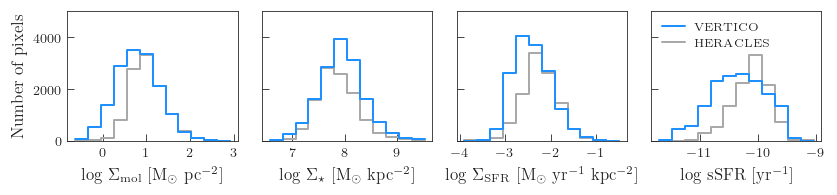

In [22]:
%matplotlib inline

# init the figure object
fig = formatter.figure(wide=True, aspect_ratio=0.25)

# no. plots and bins per plot
n_plot = 4
n_bins = 12

# add the axes
axs = []

for i in range(n_plot):
    if i == 0:
        axs.append(fig.add_subplot(1, n_plot, i + 1))
    else:
        axs.append(fig.add_subplot(1, n_plot, i + 1, sharey=axs[0]))


hist_kwargs = {
    "element": "step",
    "fill": False,
    "log_scale": False,
    "bins": n_bins,
    "hue": "survey",
    "alpha": alpha,
    "palette": ["dodgerblue", "darkgray"],
    "lw": 1.2,
}

# gas density
hist = sns.histplot(
    comb_df,
    x="lgmol_dens",
    ax=axs[0],
    legend=False,
    **hist_kwargs,
)

# stellar density
sns.histplot(
    comb_df,
    x="lgms_dens",
    ax=axs[1],
    legend=False,
    **hist_kwargs,
)

# star formation rate
sns.histplot(
    comb_df,
    x="lgsfr_dens",
    ax=axs[2],
    legend=False,
    **hist_kwargs,
)

# specific star formation rate
comb_df["lgssfr_res"] = comb_df["lgsfr_dens"] - comb_df["lgms_dens"]
h = sns.histplot(
    comb_df,
    x="lgssfr_res",
    ax=axs[3],
    legend=True,
    **hist_kwargs,
)

# tidy legend
sns.move_legend(
    h,
    "upper left",
    title="",
    fontsize="x-small",
    # bbox_to_anchor=(1.8, 1.02),
    frameon=False,
)

# tidy up the axes
for i in range(1, n_plot):
    axs[i].tick_params(labelleft=False)
    axs[i].set_ylabel("")

xlabels = [
    r"log $\Sigma_\mathrm{mol}$ [M$_{\odot}$ pc$^{-2}$]",
    r"log $\Sigma_{\star}$ [M$_{\odot}$ kpc$^{-2}$]",
    "log $\Sigma_\mathrm{SFR}$ [M$_{\odot}$ yr$^{-1}$ kpc$^{-2}$]",
    r"log sSFR [yr$^{-1}$]",
]

axs[0].xaxis.set_major_locator(MaxNLocator(4))

axs[0].set_ylim(0, 5000)
axs[0].set_ylabel("Number of pixels")
for ax, xlabel in zip(axs, xlabels):
    ax.set_xlabel(xlabel)

fig.subplots_adjust(hspace=0.05, wspace=0.05)

if write_plots:
    fig.savefig(
        "figs/dist_resolved.pdf",
        metadata={
            "Author": "Toby Brown",
        },
        bbox_inches="tight",
    )

fig.tight_layout()

# 4. $\Delta \Sigma_\mathrm{SFR}$, $\Delta f_\mathrm{mol}$, and $\Delta SFE$ in inner and outer disc as a function of Yoon+17 classes

In [23]:
category_count = comb_df.groupby(["y17_physical"]).size()
pix_count_df = comb_df.groupby(["y17_physical", "disc_region"]).size()
pix_pc_df = pix_count_df / category_count * 100

In [24]:
comb_df["disc_region"].unique()

['outer disc', 'inner disc']
Categories (2, object): ['inner disc' < 'outer disc']

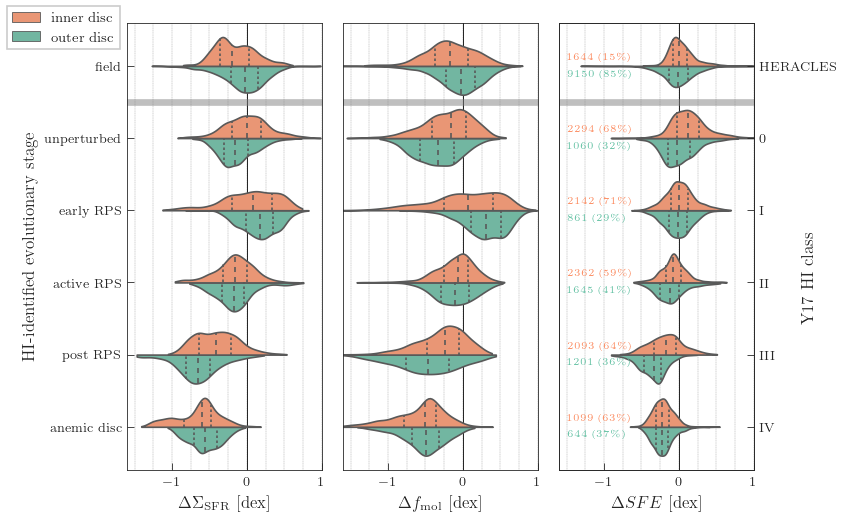

In [25]:
# group the Yoon classes into early (0), active (I + II), past (III + IV)
# pandas groupby doesn't like strings so we assign a numerical key that we'll convert in the next plot

# set up the figure
fig = formatter.figure(wide=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

hue_order = ["outer disc", "inner disc"]

violin_kwargs = {
    "categories": categories,
    "order": categories[::-1],
    "hue_order": hue_order,
    "split": True,
    "scale": "area",
    "inner": "quartile",
    "cut": 0,
    "orient": "h",
    "dodge": False,
    "palette": "Set2",
}
sns.violinplot(
    data=comb_df,
    x="delta_sfr",
    y="y17_physical",
    hue="disc_region",
    ax=ax1,
    **violin_kwargs
)

v = sns.violinplot(
    data=comb_df,
    x="delta_fmol",
    y="y17_physical",
    hue="disc_region",
    ax=ax2,
    **violin_kwargs
)

sns.violinplot(
    data=comb_df,
    x="delta_sfe",
    y="y17_physical",
    hue="disc_region",
    ax=ax3,
    **violin_kwargs
)


# posterior
for ax in [ax1, ax2, ax3]:
    ax.get_legend().remove()
    ax.vlines(0, -100, 100, color="k", ls="-", lw=0.5, zorder=0)
    ax.vlines(
        np.arange(-2, 2, 0.25), -10, 10, color="k", ls="--", lw=0.2, alpha=0.5, zorder=0
    )
    ax.hlines([4.5], -100, 100, color="grey", ls="-", lw=4, alpha=0.5)
    ax.set_ylim(-0.6, 5.6)
    ax.set_xlim(-1.6, 1)
    ax.set_ylabel("")

# annotate % of pixels
for i, cat in enumerate(comb_df["y17_physical"].unique()):
    for loc in hue_order:
        cpalette = sns.color_palette("Set2", n_colors=2).as_hex()
        if loc == hue_order[0]:
            c = cpalette[0]
            offset = -5
        else:
            c = cpalette[1]
            offset = 5

        ax3.annotate(
            "{:} ({:}\%)".format(pix_count_df[cat][loc], round(pix_pc_df[cat][loc])),
            xy=(-1.5, i),
            xytext=(0, offset),
            textcoords="offset points",
            c=c,
            va="center",
            ha="left",
            fontsize="xx-small",
        )

# twin y showing Y17 classes
twiny = ax3.twinx()
mn, mx = ax3.get_ylim()
twiny.set_ylim(mx, mn)
twiny.set_yticks(ax3.get_yticks())
twiny.set_yticklabels(["HERACLES", "0", "I", "II", "III", "IV"])
twiny.set_ylabel(r"Y17 H{\sc I} class")
twiny.yaxis.set_label_coords(1.25, 0.43)

ax2.set_yticks([])
ax3.set_yticks([])

ax1.set_ylabel(r"H{\sc I}-identified evolutionary stage")
ax1.set_xlabel(r"$\Delta \Sigma_\mathrm{SFR}$ [dex]")
ax2.set_xlabel(r"$\Delta f_\mathrm{mol}$ [dex]")
ax3.set_xlabel(r"$\Delta SFE$ [dex]")

handles, labels = v.get_legend_handles_labels()
fig.legend(
    handles=handles[::-1],
    labels=labels[::-1],
    loc="upper left",
    fontsize="small",
    frameon=True,
    facecolor="w",
)

fig.subplots_adjust(wspace=0.0)
fig.tight_layout()

if write_plots:
    fig.savefig(
        "figs/delta_quants_radius_Y17.pdf",
        metadata={
            "Author": "Toby Brown",
        },
        bbox_inches="tight",
    )

# 5. Classify pixels as belonging to gas poor / normal galaxies



In [26]:
hidef_transition = 0.5
hipoor_i = df.index[df["viva_hi-def"] >= hidef_transition].tolist()
hinormal_i = df.index[df["viva_hi-def"] < hidef_transition].tolist()

df["HI-status"] = "HI--def $< {:.1f}$".format(hidef_transition)
df.loc[hipoor_i, "HI-status"] = "HI--def $\geq {:.1f}$".format(hidef_transition)

In [27]:
# galaxy df with the same gas poor / normal flag
groupdf = grouped.mean(numeric_only=True)

ghipoor_i = groupdf.index[groupdf["viva_hi-def"] < hidef_transition].tolist()
ghinormal_i = groupdf.index[groupdf["viva_hi-def"] >= hidef_transition].tolist()

groupdf["HI-status"] = "HI--def $< {:.1f}$".format(hidef_transition)
groupdf.loc[ghipoor_i, "HI-status"] = "HI--def $\geq {:.1f}$".format(hidef_transition)

In [28]:
print("{} pixels in {} HI-poor galaxies".format(len(hipoor_i), len(ghipoor_i)))
print("{} pixels in {} HI-normal galaxies".format(len(hinormal_i), len(ghinormal_i)))

6448 pixels in 16 HI-poor galaxies
8953 pixels in 17 HI-normal galaxies


In [29]:
print("\nSFMS:")
print(
    "HI-normal avg delta SFR = {:.2f}".format(df.loc[hinormal_i]["delta_sfr"].median())
)
avgdiff_sfms = (
    df.loc[hipoor_i]["delta_sfr"].median() - df.loc[hinormal_i]["delta_sfr"].median()
)
print("HI-poor avg delta SFR = {:.2f}".format(df.loc[hipoor_i]["delta_sfr"].median()))
print("Diff in avg delta SFR = {:.2f}".format(avgdiff_sfms))

print("\nMGMS:")
print(
    "HI-normal avg delta fmol = {:.2f}".format(
        df.loc[hinormal_i]["delta_fmol"].median()
    )
)
avgdiff_mgms = (
    df.loc[hipoor_i]["delta_fmol"].median() - df.loc[hinormal_i]["delta_fmol"].median()
)
print("HI-poor avg delta fmol = {:.2f}".format(df.loc[hipoor_i]["delta_fmol"].median()))
print("Diff in avg delta fmol = {:.2f}".format(avgdiff_mgms))

print("\nKSR:")
print(
    "HI-normal avg delta SFE = {:.2f}".format(df.loc[hinormal_i]["delta_sfe"].median())
)
avgdiff_ksr = (
    df.loc[hipoor_i]["delta_sfe"].median() - df.loc[hinormal_i]["delta_sfe"].median()
)
print("HI-poor avg delta SFE = {:.2f}".format(df.loc[hipoor_i]["delta_sfe"].median()))
print("Diff in avg delta SFE = {:.2f}".format(avgdiff_ksr))


SFMS:
HI-normal avg delta SFR = 0.01
HI-poor avg delta SFR = -0.53
Diff in avg delta SFR = -0.53

MGMS:
HI-normal avg delta fmol = -0.02
HI-poor avg delta fmol = -0.40
Diff in avg delta fmol = -0.38

KSR:
HI-normal avg delta SFE = 0.01
HI-poor avg delta SFE = -0.21
Diff in avg delta SFE = -0.22


# 6. Fit the rSFMS, rMGMS, and rKSR

sig_int:     0.0000      1.7651
Computing sig_int
sig_int:     0.0000      1.7651
sig_int:     0.2922     -0.2856
sig_int:     0.2515     -0.0811
sig_int:     0.2361      0.0169
sig_int:     0.2388     -0.0010
sig_int:     0.2386     -0.0000
sig_int:     0.2385      0.0008
Computing sig_int error
sig_int:     0.2386      0.0177
sig_int:     0.2922     -0.2678
sig_int:     0.2420     -0.0041
sig_int:     0.2413     -0.0000
sig_int:     0.2412      0.0007
Repeat at best fitting solution
sig_int:     0.2386     -0.0000
################# Values and formal errors ################
 intercept:  -2.5716 +/- 0.0034
     slope:  0.696 +/- 0.010
   scatter:  0.2386 +/- 0.0027
Observed rms scatter: 0.27
y = a + b*(x - pivot) with pivot = 8.157
Spearman r=0.62 and p=0
Pearson r=0.62 and p=0
##########################################################
seconds 67.50
sig_int:     0.0000      3.3892
Computing sig_int
sig_int:     0.0000      3.3892
sig_int:     0.3135     -0.3256
sig_int:     0.2860     

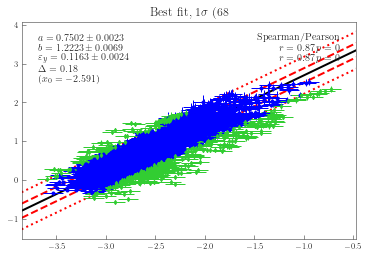

sig_int:     0.0000      1.5041
Computing sig_int
sig_int:     0.0000      1.5041
sig_int:     0.2599     -0.3687
sig_int:     0.2088     -0.1385
sig_int:     0.1806      0.0351
sig_int:     0.1862     -0.0009
sig_int:     0.1861      0.0001
Computing sig_int error
sig_int:     0.1861      0.0154
sig_int:     0.2599     -0.3534
sig_int:     0.1892     -0.0039
sig_int:     0.1885     -0.0004
sig_int:     0.1885      0.0002
Repeat at best fitting solution
sig_int:     0.1861      0.0001
################# Values and formal errors ################
 intercept:  0.7847 +/- 0.0026
     slope:  1.1863 +/- 0.0064
   scatter:  0.1861 +/- 0.0024
Observed rms scatter: 0.24
y = a + b*(x - pivot) with pivot = -2.327
Spearman r=0.83 and p=0
Pearson r=0.84 and p=0
##########################################################
seconds 80.38


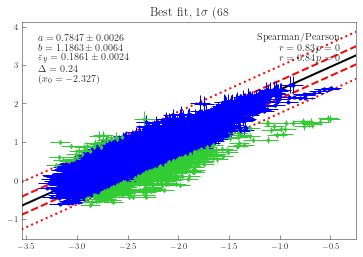

In [30]:
# Compute fits to each sub-sample
frac = 0.5

# rSFMS
sfms_fits = []
for sample in [hipoor_i, hinormal_i]:
    x = df["lgms_dens"].loc[sample].values
    y = df["lgsfr_dens"].loc[sample].values

    fit = lts(
        x,
        y,
        sigx=np.zeros(len(x)) + 0.1,
        sigy=np.zeros(len(x)) + 0.1,
        pivot=np.median(x),
        plot=False,
        frac=frac,
    )

    fit.pivot = np.median(x)

    sfms_fits.append(fit)

# rMGMS
mgms_fits = []
for sample in [hipoor_i, hinormal_i]:
    x = df["lgms_dens"].loc[sample].values
    y = df["lgmol_dens"].loc[sample].values

    fit = lts(
        x,
        y,
        sigx=np.zeros(len(x)) + 0.1,
        sigy=df["mom0_unc"].loc[sample].values,
        pivot=np.median(x),
        plot=False,
        frac=frac,
    )

    fit.pivot = np.median(x)

    mgms_fits.append(fit)

# rKSR
ks_fits = []
for sample in [hipoor_i, hinormal_i]:
    x = df["lgsfr_dens"].loc[sample].values
    y = df["lgmol_dens"].loc[sample].values

    fit = lts(
        x0=x,
        y=y,
        sigx=np.zeros(len(x)) + 0.1,
        sigy=df["mom0_unc"].loc[sample].values,
        pivot=np.median(x),
        plot=True,
        frac=frac,
    )

    fit.pivot = np.median(x)

    ks_fits.append(fit)
    plt.show()

sig_int:     0.0000      3.2370
Computing sig_int
sig_int:     0.0000      3.2370
sig_int:     0.2878     -0.3086
sig_int:     0.2627     -0.1976
sig_int:     0.2207      0.0549
sig_int:     0.2298     -0.0110
sig_int:     0.2283     -0.0007
sig_int:     0.2282      0.0001
Computing sig_int error
sig_int:     0.2282      0.0139
sig_int:     0.2878     -0.2948
sig_int:     0.2309     -0.0042
sig_int:     0.2303     -0.0000
sig_int:     0.2302      0.0007
Repeat at best fitting solution
sig_int:     0.2282      0.0001
################# Values and formal errors ################
 intercept:  -2.2569 +/- 0.0025
     slope:  0.6893 +/- 0.0065
   scatter:  0.2282 +/- 0.0021
Observed rms scatter: 0.26
y = a + b*(x - pivot) with pivot = 7.84
Spearman r=0.66 and p=0
Pearson r=0.67 and p=0
##########################################################
seconds 92.73
sig_int:     0.0000     -0.2558
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.2

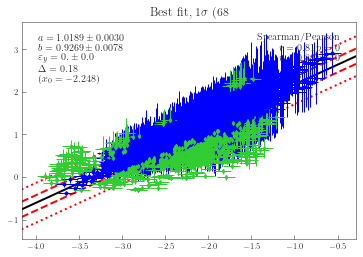

In [31]:
# Compute fits to HERACLES

# rSFMS
x = heradf["lgms_dens"].values
y = heradf["lgsfr_dens"].values

hera_sfms_fit = lts(
    x,
    y,
    sigx=np.zeros(len(x)) + 0.1,
    sigy=np.zeros(len(x)) + 0.1,
    pivot=np.median(x),
    plot=False,
    frac=frac,
)

hera_sfms_fit.pivot = np.median(x)

# rMGMS
x = heradf["lgms_dens"].values
y = heradf["lgmol_dens"].values

hera_mgms_fit = lts(
    x,
    y,
    sigx=np.zeros(len(x)) + 0.1,
    sigy=heradf["CO_mom0_unc"].values,
    pivot=np.median(x),
    plot=False,
    frac=frac,
)

hera_mgms_fit.pivot = np.median(x)

# rKSR
x = heradf["lgsfr_dens"].values
y = heradf["lgmol_dens"].values

hera_ks_fit = lts(
    x0=x,
    y=y,
    sigx=np.zeros(len(x)) + 0.1,
    sigy=heradf["CO_mom0_unc"].values,
    pivot=np.median(x),
    plot=True,
    frac=frac,
)

hera_ks_fit.pivot = np.mean(x)

# 7. Plot the rSFMS, rMGMS, and rKSR for both VERTICO and HERACLES

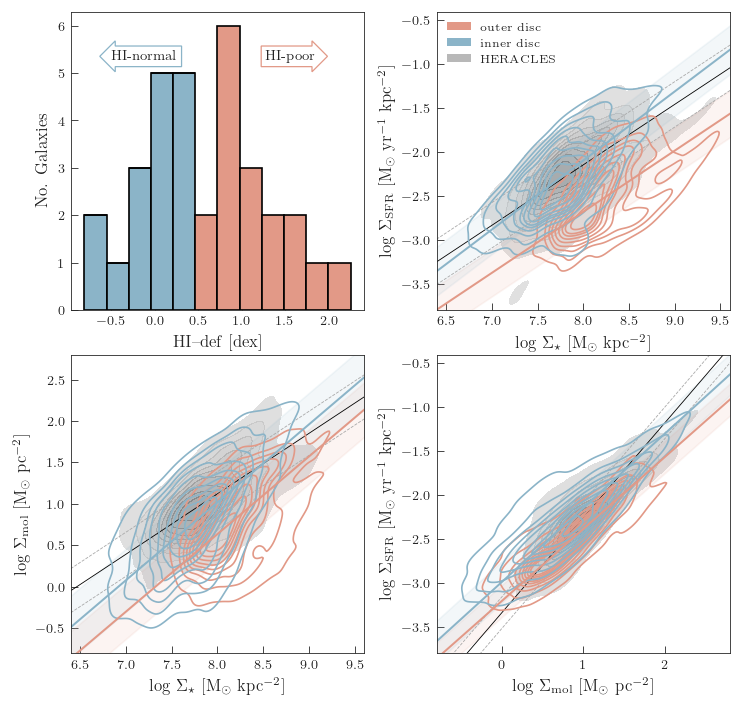

In [32]:
%matplotlib inline

# set up the figure
fig = formatter.figure(wide=True, aspect_ratio=1)
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# histogram
h = sns.histplot(
    groupdf,
    x="viva_hi-def",
    hue="HI-status",
    multiple="stack",
    bins=12,
    ax=ax1,
    legend=False,
    palette=small_palette,
    alpha=alpha,
)

# kde plots
k1 = sns.kdeplot(
    df,
    x="lgms_dens",
    y="lgsfr_dens",
    hue="HI-status",
    ax=ax2,
    legend=False,
    common_norm=False,
    palette=small_palette,
    alpha=alpha,
)

k2 = sns.kdeplot(
    df,
    x="lgms_dens",
    y="lgmol_dens",
    hue="HI-status",
    ax=ax3,
    legend=False,
    palette=small_palette,
    alpha=alpha,
)

k3 = sns.kdeplot(
    df,
    x="lgmol_dens",
    y="lgsfr_dens",
    hue="HI-status",
    ax=ax4,
    legend=False,
    palette=small_palette,
    alpha=alpha,
)

sns.kdeplot(
    heradf,
    x="lgms_dens",
    y="lgsfr_dens",
    ax=ax2,
    common_norm=False,
    color="darkgrey",
    fill=True,
    zorder=0,
    alpha=0.5,
)

sns.kdeplot(
    heradf,
    x="lgms_dens",
    y="lgmol_dens",
    ax=ax3,
    legend=False,
    common_norm=False,
    color="darkgrey",
    fill=True,
    zorder=0,
    alpha=0.5,
)

sns.kdeplot(
    heradf,
    x="lgmol_dens",
    y="lgsfr_dens",
    ax=ax4,
    legend=False,
    common_norm=False,
    color="darkgrey",
    fill=True,
    zorder=0,
    alpha=0.5,
)

# plot the fits for subsamples
fit_collections = [sfms_fits, mgms_fits]
axes = [ax2, ax3]
for ax, fits in zip(axes, fit_collections):
    for i, fit in enumerate(fits):
        xlo, xhi = ax.get_xlim()
        x = np.linspace(xlo, xhi, 10)
        a, b = fit.ab
        pivot = fit.pivot
        scatter = fit.rms

        y = a + (b * (x - pivot))
        y1 = y - scatter
        y2 = y + scatter

        ax.fill_between(x, y1, y2, color=small_palette[i], alpha=0.1)
        ax.plot(x, y, color=small_palette[i], alpha=1, lw=1.2)

for ax, fit in zip([ax2, ax3], [hera_sfms_fit, hera_mgms_fit]):
    xlo, xhi = ax.get_xlim()
    x = np.linspace(xlo, xhi, 10)
    a, b = fit.ab
    pivot = fit.pivot
    scatter = fit.rms

    # y = a + b*(x - pivot)
    y = a + (b * (x - pivot))
    y1 = y - scatter
    y2 = y + scatter

    ax.plot(x, y, color="k", alpha=1, lw=0.5, zorder=1)
    ax.plot(x, y1, color="darkgray", ls="--", alpha=1, lw=0.5, zorder=1)
    ax.plot(x, y2, color="darkgray", ls="--", alpha=1, lw=0.5, zorder=1)


# the KS relation is a special case because we fit for mmol (not SFR) density
for i, fit in enumerate(ks_fits):
    xlo, xhi = ax4.get_xlim()
    x = np.linspace(xlo, xhi, 10)
    a, b = fit.ab
    pivot = fit.pivot
    scatter = fit.rms

    y = -a / b + pivot + 1.0 / b * x
    y1 = y - scatter
    y2 = y + scatter

    ax4.fill_between(x, y1, y2, color=small_palette[i], alpha=0.1)
    ax4.plot(x, y, color=small_palette[i], alpha=1, lw=1.2)

xlo, xhi = ax4.get_xlim()
x = np.linspace(xlo, xhi, 10)
a, b = hera_ks_fit.ab
pivot = hera_ks_fit.pivot
scatter = hera_ks_fit.rms

y = -a / b + pivot + 1.0 / b * x
y1 = y - scatter
y2 = y + scatter

ax4.plot(x, y, color="k", alpha=1, lw=0.5, zorder=1)
ax4.plot(x, y1, color="darkgray", ls="--", alpha=1, lw=0.5, zorder=1)
ax4.plot(x, y2, color="darkgray", ls="--", alpha=1, lw=0.5, zorder=1)


# posterior

# annotate
ax1.text(
    0.75,
    0.85,
    "HI-poor",
    transform=ax1.transAxes,
    ha="center",
    va="center",
    rotation=0,
    size="small",
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="none", ec=small_palette[0], lw=0.75),
)

ax1.text(
    0.25,
    0.85,
    "HI-normal",
    transform=ax1.transAxes,
    ha="center",
    va="center",
    rotation=0,
    size="small",
    bbox=dict(boxstyle="larrow,pad=0.3", fc="none", ec=small_palette[1], lw=0.75),
)

ax1.set_xlabel(r"H{\sc I}--def [dex]")
ax2.set_xlabel(r"log $\Sigma_{\star} ~ \mathrm{[M_\odot ~ kpc^{-2}]}$")
ax3.set_xlabel(r"log $\Sigma_{\star} ~ \mathrm{[M_\odot ~ kpc^{-2}]}$")
ax4.set_xlabel(r"log $\Sigma_{\mathrm{mol}} ~ \mathrm{[M_\odot ~ pc^{-2}]}$")

ax1.set_ylabel("No. Galaxies")
ax2.set_ylabel(r"log $\Sigma_\mathrm{SFR} ~ \mathrm{[M_\odot ~ yr^{-1} ~ kpc^{-2}]}$")
ax3.set_ylabel(r"log $\Sigma_{\mathrm{mol}} ~ \mathrm{[M_\odot ~ pc^{-2}]}$")
ax4.set_ylabel(r"log $\Sigma_\mathrm{SFR} ~ \mathrm{[M_\odot ~ yr^{-1} ~ kpc^{-2}]}$")

sfr_lim = (-3.8, -0.4)
ms_lim = (6.4, 9.6)
mol_lim = (-0.8, 2.8)

ax2.set_xlim(ms_lim)
ax3.set_xlim(ms_lim)
ax4.set_xlim(mol_lim)
ax2.set_ylim(sfr_lim)
ax3.set_ylim(mol_lim)
ax4.set_ylim(sfr_lim)

handles = [
    mpatches.Patch(facecolor=small_palette[0], label=hue_order[0]),
    mpatches.Patch(facecolor=small_palette[1], label=hue_order[1]),
    mpatches.Patch(facecolor=plt.cm.Greys(100), label="HERACLES"),
]
ax2.legend(handles=handles, loc="upper left", fontsize="x-small", frameon=False)

fig.subplots_adjust(hspace=0.15, wspace=0.25)

if write_plots:
    fig.savefig(
        "figs/sequences_HI_normal_poor.pdf",
        metadata={
            "Author": "Toby Brown",
        },
        bbox_inches="tight",
    )

In [33]:
def get_overlap_lim(a, b):
    # return the overlap range of two arrays (only works if they overlap).
    # Note that it will be the separation if they don't (i think but untested)
    return (max(a.min(), b.min()), min(a.max(), b.max()))


avg_diffs = []
for fits in [sfms_fits, mgms_fits]:
    # evaluate fit predictions and subtract
    xlo, xhi = get_overlap_lim(
        df.loc[hipoor_i, "lgms_dens"], df.loc[hinormal_i, "lgms_dens"]
    )

    x = np.linspace(xlo, xhi, 50)

    # y = a + b*(x - pivot)
    y1 = fits[0].ab[0] + (fits[0].ab[1] * (x - fits[0].pivot))
    y2 = fits[1].ab[0] + (fits[1].ab[1] * (x - fits[1].pivot))

    print(np.mean(y1 - y2))
    avg_diffs.append(np.mean(y1 - y2))

xlo, xhi = get_overlap_lim(
    df.loc[hipoor_i, "lgmol_dens"], df.loc[hinormal_i, "lgmol_dens"]
)

x = np.linspace(xlo, xhi, 50)

y1 = -ks_fits[0].ab[0] / ks_fits[0].ab[1] + ks_fits[0].pivot + 1 / ks_fits[0].ab[1] * x
y2 = -ks_fits[1].ab[0] / ks_fits[1].ab[1] + ks_fits[1].pivot + 1 / ks_fits[1].ab[1] * x


avg_diffs.append(np.median(y1 - y2))

print(
    "Difference between HI-normal and HI-poor rSFMS best fits = {:.2f} dex".format(
        avg_diffs[0]
    )
)
print(
    "Difference between HI-normal and HI-poor rMGMS best fits = {:.2f} dex".format(
        avg_diffs[1]
    )
)
print(
    "Difference between HI-normal vs. HI-poor rKSR best fits = {:.2f} dex".format(
        avg_diffs[2]
    )
)

-0.6189153044637029
-0.38452889608971086
Difference between HI-normal and HI-poor rSFMS best fits = -0.62 dex
Difference between HI-normal and HI-poor rMGMS best fits = -0.38 dex
Difference between HI-normal vs. HI-poor rKSR best fits = -0.24 dex


In [34]:
def build_results_table(relation, fits, samplenames):
    # build an astropy table for fit results
    params = {}
    params["Relation"] = [relation for i in range(len(fits))]
    params["Sub-sample"] = samplenames

    # y = a + b*(x - pivot)
    a_list = []
    b_list = []
    pivot_list = []
    sigma_list = []

    for fit, name in zip(fits, samplenames):
        a, b = fit.ab
        a_err, b_err = fit.ab_err  # standard error on fit params

        a_list.append("{:.2f}$\pm${:.3f}".format(a, a_err))
        b_list.append("{:.2f}$\pm${:.3f}".format(b, b_err))
        pivot_list.append("{:.2f}".format(fit.pivot))
        sigma_list.append("{:.2f}".format(fit.rms))

    params["$a$"] = a_list
    params["$b$"] = b_list
    params["pivot"] = pivot_list
    params["$\sigma$"] = sigma_list

    return pd.DataFrame(params)

## Put fit results in a table for the paper

In [35]:
all_sfms_fit = [hera_sfms_fit] + sfms_fits
all_mgms_fit = [hera_mgms_fit] + mgms_fits
all_ks_fit = [hera_ks_fit] + ks_fits

# put fit parameters in a dataframe
sfms_results = build_results_table(
    "rSFMS", all_sfms_fit, ["HERACLES", "\HI-poor", "\HI-normal"]
)
mgms_results = build_results_table(
    "rMGMS", all_mgms_fit, ["HERACLES", "\HI-poor", "\HI-normal"]
)
ks_results = build_results_table(
    "rKSR", all_ks_fit, ["HERACLES", "\HI-poor", "\HI-normal"]
)

results_table = pd.concat([sfms_results, mgms_results, ks_results], ignore_index=True)

results_table

,Relation,Sub-sample,$a$,$b$,pivot,$\sigma$
0,rSFMS,HERACLES,-2.26$\pm$0.003,0.69$\pm$0.006,7.84,0.26
1,rSFMS,\HI-poor,-2.57$\pm$0.003,0.70$\pm$0.010,8.16,0.27
2,rSFMS,\HI-normal,-2.29$\pm$0.003,0.79$\pm$0.008,7.76,0.28
3,rMGMS,HERACLES,1.00$\pm$0.003,0.73$\pm$0.008,7.84,0.27
4,rMGMS,\HI-poor,0.78$\pm$0.004,0.94$\pm$0.013,8.16,0.33
5,rMGMS,\HI-normal,0.79$\pm$0.004,0.94$\pm$0.010,7.76,0.38
6,rKSR,HERACLES,1.02$\pm$0.003,0.93$\pm$0.008,-2.24,0.18
7,rKSR,\HI-poor,0.75$\pm$0.002,1.22$\pm$0.007,-2.59,0.18
8,rKSR,\HI-normal,0.78$\pm$0.003,1.19$\pm$0.006,-2.33,0.24


In [36]:
tab = Table.from_pandas(results_table)
caption = r"""Best fit parameters for the relation $y = a + (bx - \mathrm{pivot})$, 
where $x$ and $y$ are the respective axes of the relation in column (1). The units are 
given in Figure \ref{fig:sequences_HI_normal_poor}. Pivot is in the same units as $x$. 
The rms scatter, $\sigma$, of the data about the fitted relation is calculated as the 
standard deviation of $y_\mathrm{fit} - y_\mathrm{pix}$.  \label{tab:fit_params}"""

tab.write(sys.stdout, format="aastex", caption=caption)

\begin{deluxetable}{cccccc}
\tablecaption{Best fit parameters for the relation $y = a + (bx - \mathrm{pivot})$, 
where $x$ and $y$ are the respective axes of the relation in column (1). The units are 
given in Figure \ref{fig:sequences_HI_normal_poor}. Pivot is in the same units as $x$. 
The rms scatter, $\sigma$, of the data about the fitted relation is calculated as the 
standard deviation of $y_\mathrm{fit} - y_\mathrm{pix}$.  \label{tab:fit_params}}
\tablehead{\colhead{Relation} & \colhead{Sub-sample} & \colhead{$a$} & \colhead{$b$} & \colhead{pivot} & \colhead{$\sigma$}}
\startdata
rSFMS & HERACLES & -2.26$\pm$0.003 & 0.69$\pm$0.006 & 7.84 & 0.26 \\
rSFMS & \HI-poor & -2.57$\pm$0.003 & 0.70$\pm$0.010 & 8.16 & 0.27 \\
rSFMS & \HI-normal & -2.29$\pm$0.003 & 0.79$\pm$0.008 & 7.76 & 0.28 \\
rMGMS & HERACLES & 1.00$\pm$0.003 & 0.73$\pm$0.008 & 7.84 & 0.27 \\
rMGMS & \HI-poor & 0.78$\pm$0.004 & 0.94$\pm$0.013 & 8.16 & 0.33 \\
rMGMS & \HI-normal & 0.79$\pm$0.004 & 0.94$\pm$0.010 & 7.76 &

# Double check:

1. $\Delta SFE$ difference isn't driven by stellar mass surface density differences.
2. HI-normal vs. HI-poor difference isn't driven by total stellar mass

In [37]:
hi_norm_df = df.loc[df["HI-status"] == "HI--def $< 0.5$"]
hi_poor_df = df.loc[df["HI-status"] == "HI--def $\\geq 0.5$"]

bin_edges = np.arange(6.0, 9.5, 0.5)
hi_norm_binned_median = binned_statistic(
    hi_norm_df["lgms_dens"], hi_norm_df["delta_sfe"], statistic="median", bins=bin_edges
)
hi_norm_binned_std = binned_statistic(
    hi_norm_df["lgms_dens"], hi_norm_df["delta_sfe"], statistic="std", bins=bin_edges
)

hi_poor_binned_median = binned_statistic(
    hi_poor_df["lgms_dens"], hi_poor_df["delta_sfe"], statistic="median", bins=bin_edges
)

hi_poor_binned_std = binned_statistic(
    hi_poor_df["lgms_dens"], hi_poor_df["delta_sfe"], statistic="std", bins=bin_edges
)

hera_binned_median = binned_statistic(
    heradf["lgms_dens"], heradf["delta_sfe"], statistic="median", bins=bin_edges
)

hera_binned_std = binned_statistic(
    heradf["lgms_dens"], heradf["delta_sfe"], statistic="std", bins=bin_edges
)

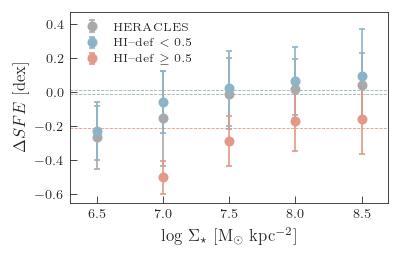

In [38]:
fig = formatter.figure(wide=False)

ax = fig.add_subplot()


ax.errorbar(
    x=bin_edges[:-1],
    y=hera_binned_median.statistic,
    yerr=hera_binned_std.statistic,
    marker="o",
    ls="",
    c="darkgray",
    ms=5,
    capsize=2,
    label="HERACLES",
)
ax.errorbar(
    x=bin_edges[:-1],
    y=hi_norm_binned_median.statistic,
    yerr=hi_norm_binned_std.statistic,
    marker="o",
    ls="",
    c=small_palette[1],
    ms=5,
    capsize=2,
    label=hi_norm_df["HI-status"].unique()[0],
)
ax.errorbar(
    x=bin_edges[:-1],
    y=hi_poor_binned_median.statistic,
    yerr=hi_poor_binned_std.statistic,
    marker="o",
    ls="",
    c=small_palette[0],
    ms=5,
    capsize=2,
    label=hi_poor_df["HI-status"].unique()[0],
)

ax.hlines(
    heradf["delta_sfe"].median(), 6, 9, ls="--", lw=0.5, color="darkgray", zorder=0
)
ax.hlines(
    hi_norm_df["delta_sfe"].median(),
    6,
    9,
    ls="--",
    lw=0.5,
    color=small_palette[1],
    zorder=0,
)
ax.hlines(
    hi_poor_df["delta_sfe"].median(),
    6,
    9,
    ls="--",
    lw=0.5,
    color=small_palette[0],
    zorder=0,
)

ax.legend(loc="upper left", fontsize="x-small", frameon=False)
ax.set_xlabel(r"log $\Sigma_{\star} ~ \mathrm{[M_\odot ~ kpc^{-2}]}$")
ax.set_ylabel(r"$\Delta SFE$ [dex]")
ax.set_xlim(6.3, 8.7)
ax.set_ylim(-0.65, 0.47)

if write_plots:
    fig.savefig(
        "figs/logms_delta_sfe_hi-status.pdf",
        metadata={
            "Author": "Toby Brown",
        },
        bbox_inches="tight",
    )

## 2. HI-def vs. $M_\star$

In [39]:
grouped.mean().columns

<ipython-input-39-5c330bd1a891>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped.mean().columns


Index(['mom0_Msun', 'mass_W1W3', 'sfr_nuv_w3', 'mom0_K', 'mom0_SN', 'mom0_unc',
       'GALEX_NUV_SN', 'WISE1_SN', 'r_kpc', 'WISE3_SN', 'logmass_L19',
       'r90_mol', 'r50_mol', 'lgMmol', 'logMHI_viva', 'logSFR_L19',
       'inclination', 'v_co', 'dM87', 'inclination_correction', 'lgms_dens',
       'lgsfr_dens', 'lgmol_dens', 'lgsSFR', 'lgSFE', 'lgfhi', 'lgfmol',
       'lgftot', 'hi-def_ms', 'hi-def_ms_err_lo', 'hi-def_ms_err_hi',
       'viva_hi-def', 'viva_e_hi-def', 'delta_sfr', 'delta_fmol', 'delta_sfe'],
      dtype='object')

<ipython-input-40-13f78aff8940>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = grouped.mean()["logmass_L19"]
<ipython-input-40-13f78aff8940>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y = grouped.mean()["viva_hi-def"]
<ipython-input-40-13f78aff8940>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yerr = grouped.mean()["viva_e_hi-def"]
<ipython-input-40-13f78aff8940>:30: FutureWarning: The default value of

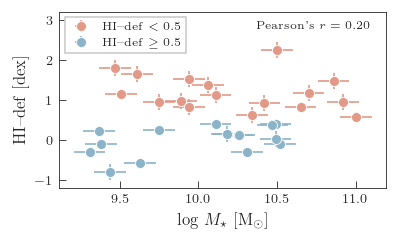

In [40]:
# set up the figure
fig = formatter.figure(wide=False)
ax = fig.add_subplot()

x = grouped.mean()["logmass_L19"]
y = grouped.mean()["viva_hi-def"]
yerr = grouped.mean()["viva_e_hi-def"]

for i, subsample in enumerate([ghinormal_i, ghipoor_i]):
    if subsample == ghinormal_i:
        label = "HI--def $< 0.5$"
    elif subsample == ghipoor_i:
        label = "HI--def $\geq 0.5$"

    ax.errorbar(
        x.loc[subsample],
        y.loc[subsample],
        yerr=yerr.loc[subsample],
        xerr=0.1,
        color=small_palette[i],
        label=label,
        marker=".",
        linestyle="",
        mec="w",
        ms=12,
        mew=0.5,
    )

# annotate pearson r
pearsonr = stats.pearsonr(grouped.mean()["logmass_L19"], grouped.mean()["viva_hi-def"])[
    0
]
ax.annotate(
    "Pearson's $r = {:.2f}$".format(pearsonr),
    xy=(0.95, 0.95),
    xycoords="axes fraction",
    fontsize="x-small",
    ha="right",
    va="top",
)

# posterior
ax.set_ylabel(r"H{\sc I}--def [dex]")
ax.set_xlabel("log $M_\star ~ \mathrm{[M_\odot]}$")

ax.legend(loc="upper left", title="", fontsize="x-small", frameon=True)
ax.set_ylim(-1.2, 3.2)
fig.tight_layout()

if write_plots:
    fig.savefig(
        "figs/hi-def_stellar_mass.pdf",
        metadata={
            "Author": "Toby Brown",
        },
        bbox_inches="tight",
    )

In [41]:
# classify pixels as belonging to hi lo mass galaxies
mass_transition = 10.2
hi_mass = df.index[df["logmass_L19"] >= mass_transition].tolist()
lo_mass = df.index[df["logmass_L19"] < mass_transition].tolist()

df["mass-status"] = r"log $M_\star < {:.1f}$".format(mass_transition)
df.loc[hi_mass, "mass-status"] = r"log $M_\star \geq {:.1f}$".format(mass_transition)

In [42]:
# classify galaxies as hi/lo mass
ghi_mass = groupdf.index[groupdf["logmass_L19"] >= mass_transition].tolist()
glo_mass = groupdf.index[groupdf["logmass_L19"] < mass_transition].tolist()

groupdf["mass-status"] = r"log $M_\star < {:.1f}$".format(mass_transition)
groupdf.loc[ghi_mass, "mass-status"] = r"log $M_\star \geq {:.1f}$".format(
    mass_transition
)

In [43]:
print("\nSFMS:")
print("high mass avg delta SFR = {:.2f}".format(df.loc[hi_mass]["delta_sfr"].median()))
print("low mass avg delta SFR = {:.2f}".format(df.loc[lo_mass]["delta_sfr"].median()))
avgdiff_sfms = (
    df.loc[hi_mass]["delta_sfr"].median() - df.loc[lo_mass]["delta_sfr"].median()
)
print("Diff in avg delta SFR = {:.2f}".format(avgdiff_sfms))

print("\nMGMS:")
print(
    "high mass avg delta fmol = {:.2f}".format(df.loc[hi_mass]["delta_fmol"].median())
)
print("low mass avg delta fmol = {:.2f}".format(df.loc[lo_mass]["delta_fmol"].median()))
avgdiff_mgms = (
    df.loc[hi_mass]["delta_fmol"].median() - df.loc[lo_mass]["delta_fmol"].median()
)
print("Diff in avg delta fmol = {:.2f}".format(avgdiff_mgms))

print("\nKSR:")
print("high mass avg delta SFE = {:.2f}".format(df.loc[hi_mass]["delta_sfe"].median()))
print("low mass avg delta SFE = {:.2f}".format(df.loc[lo_mass]["delta_sfe"].median()))
avgdiff_ksr = (
    df.loc[hi_mass]["delta_sfe"].median() - df.loc[lo_mass]["delta_sfe"].median()
)
print("Diff in avg delta SFE = {:.2f}".format(avgdiff_ksr))


SFMS:
high mass avg delta SFR = -0.23
low mass avg delta SFR = -0.14
Diff in avg delta SFR = -0.08

MGMS:
high mass avg delta fmol = -0.16
low mass avg delta fmol = -0.26
Diff in avg delta fmol = 0.09

KSR:
high mass avg delta SFE = -0.10
low mass avg delta SFE = -0.03
Diff in avg delta SFE = -0.06


sig_int:     0.0000      2.4122
Computing sig_int
sig_int:     0.0000      2.4122
sig_int:     0.3829     -0.2623
sig_int:     0.3454     -0.1359
sig_int:     0.3072      0.0240
sig_int:     0.3129     -0.0022
sig_int:     0.3124     -0.0000
sig_int:     0.3123      0.0007
Computing sig_int error
sig_int:     0.3124      0.0132
sig_int:     0.3829     -0.2490
sig_int:     0.3160     -0.0027
sig_int:     0.3154     -0.0000
sig_int:     0.3152      0.0007
Repeat at best fitting solution
sig_int:     0.3124     -0.0000
################# Values and formal errors ################
 intercept:  -2.3887 +/- 0.0035
     slope:  0.3005 +/- 0.0083
   scatter:  0.3124 +/- 0.0030
Observed rms scatter: 0.37
y = a + b*(x - pivot) with pivot = 8
Spearman r=0.25 and p=2.1e-161
Pearson r=0.31 and p=1.9e-257
##########################################################
seconds 95.11
sig_int:     0.0000      1.3229
Computing sig_int
sig_int:     0.0000      1.3229
sig_int:     0.3351     -0.3501
sig_int:    

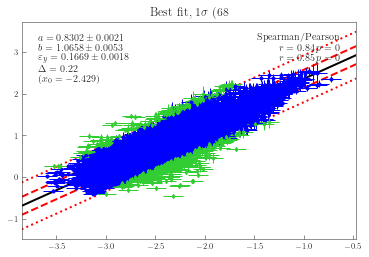

sig_int:     0.0000      4.8527
Computing sig_int
sig_int:     0.0000      4.8527
sig_int:     0.3864     -0.3838
sig_int:     0.3581     -0.2910
sig_int:     0.2744      0.1311
sig_int:     0.3004     -0.0284
sig_int:     0.2957     -0.0029
sig_int:     0.2952      0.0002
sig_int:     0.2954     -0.0007
Computing sig_int error
sig_int:     0.2952      0.0227
sig_int:     0.3864     -0.3613
sig_int:     0.3006     -0.0073
sig_int:     0.2993      0.0002
sig_int:     0.2994     -0.0006
Repeat at best fitting solution
sig_int:     0.2952      0.0002
################# Values and formal errors ################
 intercept:  0.5714 +/- 0.0050
     slope:  0.952 +/- 0.012
   scatter:  0.2952 +/- 0.0041
Observed rms scatter: 0.32
y = a + b*(x - pivot) with pivot = -2.468
Spearman r=0.74 and p=0
Pearson r=0.76 and p=0
##########################################################
seconds 49.36


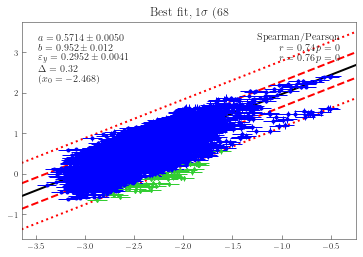

In [44]:
# Compute fits to each sub-sample

# rSFMS
sfms_fits = []
for sample in [hi_mass, lo_mass]:
    x = df["lgms_dens"].loc[sample].values
    y = df["lgsfr_dens"].loc[sample].values

    fit = lts(
        x,
        y,
        sigx=np.zeros(len(x)) + 0.1,
        sigy=np.zeros(len(x)) + 0.2,
        pivot=np.mean(x),
        plot=False,
        frac=frac,
    )

    fit.pivot = np.mean(x)

    plt.show()

    sfms_fits.append(fit)

# rMGMS
mgms_fits = []
for sample in [hi_mass, lo_mass]:
    x = df["lgms_dens"].loc[sample].values
    y = df["lgmol_dens"].loc[sample].values

    fit = lts(
        x,
        y,
        sigx=np.zeros(len(x)) + 0.1,
        sigy=np.zeros(len(x)) + 0.1,
        pivot=np.mean(x),
        plot=False,
        frac=frac,
    )

    fit.pivot = np.mean(x)

    plt.show()

    mgms_fits.append(fit)

# rKSR
ks_fits = []
for sample in [hi_mass, lo_mass]:
    x = df["lgsfr_dens"].loc[sample].values
    y = df["lgmol_dens"].loc[sample].values

    fit = lts(
        x0=x,
        y=y,
        sigx=np.zeros(len(x)) + 0.1,
        sigy=df["mom0_unc"].loc[sample].values,
        pivot=np.median(x),
        plot=True,
        frac=frac,
    )

    fit.pivot = np.median(x)

    ks_fits.append(fit)

    plt.show()

In [45]:
# choose the colors
full_palette = sns.color_palette("Set2", 6)
small_palette = list(np.array(full_palette.as_hex())[[0, 1]])
alpha = 1
full_palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961)]

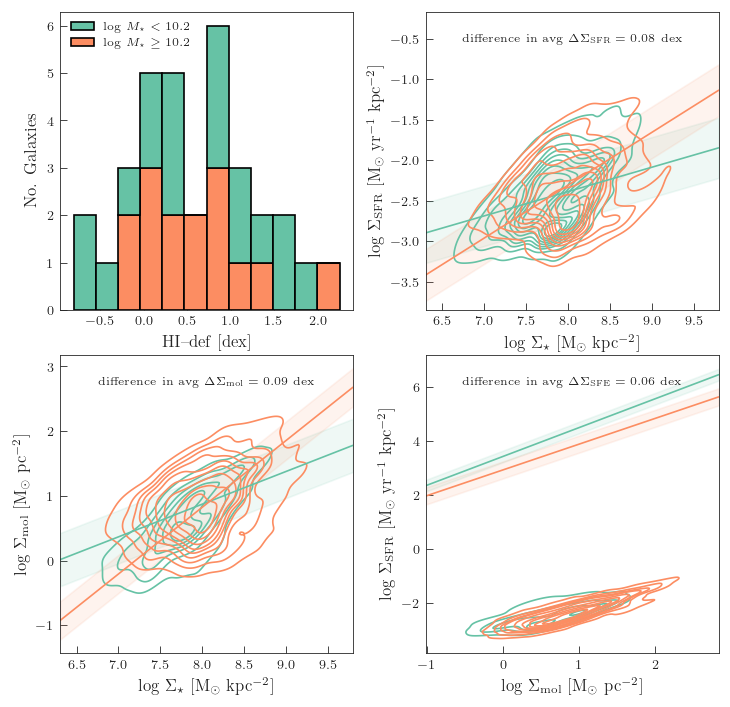

In [46]:
%matplotlib inline

# set up the figure
fig = formatter.figure(wide=True, aspect_ratio=1)
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# histogram
h = sns.histplot(
    groupdf,
    x="viva_hi-def",
    hue="mass-status",
    multiple="stack",
    bins=12,
    ax=ax1,
    palette=small_palette,
    alpha=alpha,
)

# kde plots
k1 = sns.kdeplot(
    df,
    x="lgms_dens",
    y="lgsfr_dens",
    hue="mass-status",
    ax=ax2,
    legend=False,
    common_norm=False,
    palette=small_palette,
    alpha=alpha,
)

k2 = sns.kdeplot(
    df,
    x="lgms_dens",
    y="lgmol_dens",
    hue="mass-status",
    ax=ax3,
    legend=False,
    palette=small_palette,
    alpha=alpha,
)

k3 = sns.kdeplot(
    df,
    x="lgmol_dens",
    y="lgsfr_dens",
    hue="mass-status",
    ax=ax4,
    legend=False,
    palette=small_palette,
    alpha=alpha,
)

# plot the fits for subsamples
fit_collections = [sfms_fits, mgms_fits, ks_fits]
axes = [ax2, ax3, ax4]
for ax, fits in zip(axes, fit_collections):
    for i, fit in enumerate(fits):
        xlo, xhi = ax.get_xlim()
        a, b = fit.ab
        pivot = fit.pivot
        scatter = fit.rms
        x = np.linspace(xlo, xhi, 50)

        # y = a + b*(x - pivot)
        y = a + (b * (x - pivot))
        y1 = y - scatter
        y2 = y + scatter

        ax.fill_between(x, y1, y2, color=small_palette[i], alpha=0.1)
        ax.plot(x, y, color=small_palette[i], alpha=1)

# annotate
ax2.annotate(
    "difference in avg $\Delta \Sigma_{{\mathrm{{SFR}}}} = {:.2f}$ dex".format(
        np.abs(avgdiff_sfms)
    ),
    xy=(0.5, 0.925),
    xycoords="axes fraction",
    fontsize="x-small",
    ha="center",
    va="top",
)

ax3.annotate(
    "difference in avg $\Delta \Sigma_{{\mathrm{{mol}}}} = {:.2f}$ dex".format(
        np.abs(avgdiff_mgms)
    ),
    xy=(0.5, 0.925),
    xycoords="axes fraction",
    fontsize="x-small",
    ha="center",
    va="top",
)

ax4.annotate(
    "difference in avg $\Delta \Sigma_{{\mathrm{{SFE}}}} = {:.2f}$ dex".format(
        np.abs(avgdiff_ksr)
    ),
    xy=(0.5, 0.925),
    xycoords="axes fraction",
    fontsize="x-small",
    ha="center",
    va="top",
)

# posterior
sns.move_legend(h, "upper left", title="", fontsize="x-small", frameon=False)

ax1.set_xlabel(r"H{\sc I}--def [dex]")
ax2.set_xlabel(r"log $\Sigma_{\star} ~ \mathrm{[M_\odot ~ kpc^{-2}]}$")
ax3.set_xlabel(r"log $\Sigma_{\star} ~ \mathrm{[M_\odot ~ kpc^{-2}]}$")
ax4.set_xlabel(r"log $\Sigma_{\mathrm{mol}} ~ \mathrm{[M_\odot ~ pc^{-2}]}$")

ax1.set_ylabel("No. Galaxies")
ax2.set_ylabel(r"log $\Sigma_\mathrm{SFR} ~ \mathrm{[M_\odot ~ yr^{-1} ~ kpc^{-2}]}$")
ax3.set_ylabel(r"log $\Sigma_{\mathrm{mol}} ~ \mathrm{[M_\odot ~ pc^{-2}]}$")
ax4.set_ylabel(r"log $\Sigma_\mathrm{SFR} ~ \mathrm{[M_\odot ~ yr^{-1} ~ kpc^{-2}]}$")

fig.subplots_adjust(hspace=0.15, wspace=0.25)

if write_plots:
    fig.savefig(
        "figs/sequences_hi_lo_mass.pdf",
        metadata={
            "Author": "Toby Brown",
        },
        bbox_inches="tight",
    )

In [47]:
# mean HI deficiency of each sub-sample
print(
    "avg HI-def (lo mass) = {:.2f}".format(groupdf["viva_hi-def"].loc[glo_mass].mean())
)
print(
    "avg HI-def (hi mass) = {:.2f}".format(groupdf["viva_hi-def"].loc[ghi_mass].mean())
)

print("N (lo mass) = {:}".format(len(glo_mass)))
print("N (hi mass) = {:}".format(len(ghi_mass)))

avg HI-def (lo mass) = 0.60
avg HI-def (hi mass) = 0.63
N (lo mass) = 18
N (hi mass) = 15


In [48]:
## print("\nSFMS:")
print("low mass avg delta SFR = {:.2f}".format(df.loc[lo_mass]["delta_sfr"].median()))
print("high mass avg delta SFR = {:.2f}".format(df.loc[hi_mass]["delta_sfr"].median()))
avgdiff_sfms = (
    df.loc[lo_mass]["delta_sfr"].median() - df.loc[hi_mass]["delta_sfr"].median()
)
print("Diff in avg delta SFR = {:.2f}".format(avgdiff_sfms))

print("\nMGMS:")
print("low mass avg delta fmol = {:.2f}".format(df.loc[lo_mass]["delta_fmol"].median()))
print(
    "high mass avg delta fmol = {:.2f}".format(df.loc[hi_mass]["delta_fmol"].median())
)
avgdiff_mgms = (
    df.loc[lo_mass]["delta_fmol"].median() - df.loc[hi_mass]["delta_fmol"].median()
)
print("Diff in avg delta fmol = {:.2f}".format(avgdiff_mgms))

print("\nKSR:")
print("low mass avg delta SFE = {:.2f}".format(df.loc[lo_mass]["delta_sfe"].median()))
print("high mass avg delta SFE = {:.2f}".format(df.loc[hi_mass]["delta_sfe"].median()))
avgdiff_ksr = (
    df.loc[lo_mass]["delta_sfe"].median() - df.loc[hi_mass]["delta_sfe"].median()
)
print("Diff in avg delta SFE = {:.2f}".format(avgdiff_ksr))

low mass avg delta SFR = -0.14
high mass avg delta SFR = -0.23
Diff in avg delta SFR = 0.08

MGMS:
low mass avg delta fmol = -0.26
high mass avg delta fmol = -0.16
Diff in avg delta fmol = -0.09

KSR:
low mass avg delta SFE = -0.03
high mass avg delta SFE = -0.10
Diff in avg delta SFE = 0.06


In [49]:
# put fit parameters in a dataframe
sfms_results = build_results_table("rSFMS", sfms_fits, ["hi mass", "lo mass"])
mgms_results = build_results_table("rMGMS", mgms_fits, ["hi mass", "lo mass"])
ks_results = build_results_table("rKSR", ks_fits, ["hi mass", "lo mass"])

results_table = pd.concat([sfms_results, mgms_results, ks_results], ignore_index=True)

results_table

,Relation,Sub-sample,$a$,$b$,pivot,$\sigma$
0,rSFMS,hi mass,-2.39$\pm$0.003,0.30$\pm$0.008,8.00,0.37
1,rSFMS,lo mass,-2.44$\pm$0.005,0.65$\pm$0.012,7.80,0.32
2,rMGMS,hi mass,0.87$\pm$0.004,0.51$\pm$0.009,8.00,0.41
3,rMGMS,lo mass,0.62$\pm$0.005,1.03$\pm$0.011,7.80,0.29
4,rKSR,hi mass,0.83$\pm$0.002,1.07$\pm$0.005,-2.43,0.22
5,rKSR,lo mass,0.57$\pm$0.005,0.95$\pm$0.012,-2.47,0.32
